# Assignment 1: Analysis of Blood Vessel Compliance

**Author:** Kacper Koźmin
**Album Number:** 268571
**Date:** October 8, 2025

## Loading necessary libraries

## Definition of functions and visualization of theoretical models
The functions were defined based on the formulas from the assignment sheet. The parameters in this part of the tasks were selected for the best visualization of the models on the charts.

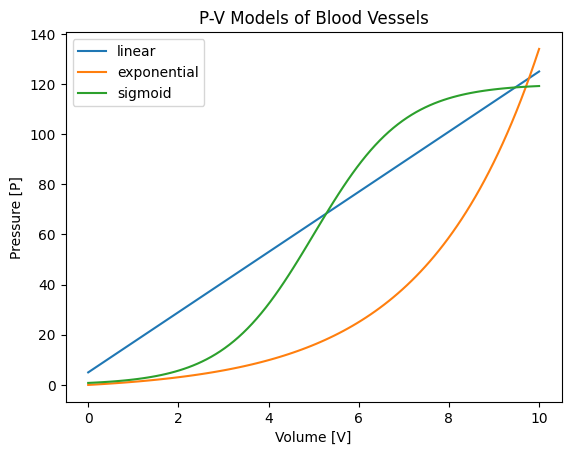

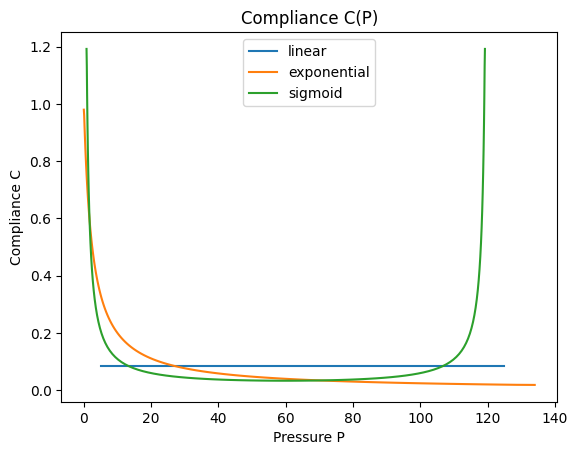

In [30]:
def linear_model (V, a, b):
    return V * a + b

def exponential_model(V, P0, alpha, V0):
    return P0 * (np.exp(alpha * (V - V0)) - 1)

def logistic_model(V, P_max, beta, V50):
    return P_max / (1 + np.exp(-beta * (V - V50)))


V = np.linspace(0,10,100)


P_linear = linear_model(V, 12, 5)
P_exponential = exponential_model(V, 2.5, 0.4, 0)
P_logistic = logistic_model(V, 120, 1, 5)

dP_dV_linear = np.gradient(P_linear, V)
dP_dV_exponential = np.gradient(P_exponential, V)
dP_dV_logistic = np.gradient(P_logistic, V)

C_linear = 1 / dP_dV_linear
C_exponential = 1 / dP_dV_exponential
C_logistic = 1 / dP_dV_logistic



plt.plot(V, P_linear, label = 'linear')
plt.plot(V, P_exponential, label = 'exponential')
plt.plot(V, P_logistic, label = 'sigmoid')
plt.xlabel('Volume [V]')
plt.ylabel('Pressure [P]')
plt.legend()
plt.title('P-V Models of Blood Vessels')
plt.show()



plt.plot(P_linear, C_linear, label = 'linear')
plt.plot(P_exponential, C_exponential, label = 'exponential')
plt.plot(P_logistic, C_logistic, label = 'sigmoid')
plt.xlabel('Pressure P')
plt.ylabel('Compliance C')
plt.legend()
plt.title('Compliance C(P)')
plt.show()

## Windkessel Model

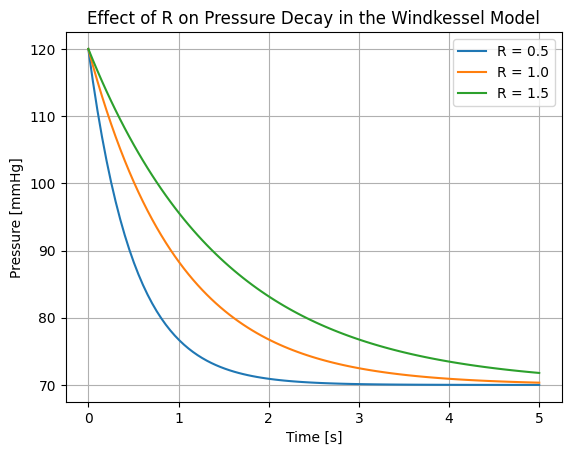

In [31]:
def windkessel_model(t, R, C, Pi, Pd):
    return Pd + (Pi - Pd) * np.exp(-t / (R * C))

C = 1.0
Pi = 120 
Pd = 70   
R_values = [0.5, 1.0, 1.5] 
t = np.linspace(0, 5, 100) 

for R in R_values:
    P_t = windkessel_model(t, R, C, Pi, Pd)
    plt.plot(t, P_t, label=f'R = {R}')

plt.xlabel('Time [s]')
plt.ylabel('Pressure [mmHg]')
plt.title('Effect of R on Pressure Decay in the Windkessel Model')
plt.legend()
plt.grid(True)
plt.show()

## Loading and visualizing patient data

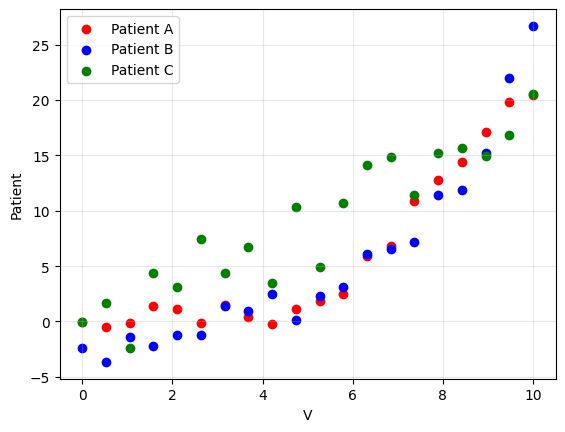

In [32]:
df = pd.read_csv('patients.csv')

plt.scatter(df['V'], df['PA'], label = 'Patient A', color = 'red')
plt.scatter(df['V'], df['PB'], label = 'Patient B', color = 'blue')
plt.scatter(df['V'], df['PC'], label = 'Patient C', color = 'green')
plt.xlabel('V')
plt.ylabel('Patient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Graded Assignment
Creating a model dictionary, fitting the best models for each patient using curve_fit, and calculating the Sum of Squared Residuals (SSR).

In [33]:
models = {
    'linear': linear_model,
    'exponential': exponential_model,
    'logistic': logistic_model
}

patient_columns = ['PA', 'PB', 'PC']
results = {}

for patient_column in patient_columns:
    results[patient_column] = {}
    y_data = df[patient_column]
    x_data = df['V']
    for model_name, model_function in models.items():
        try:
            params, _ = curve_fit(model_function, x_data, y_data, maxfev=5000)
            fit = model_function(x_data, *params)
            ssr = np.sum((y_data - fit)**2)
            results[patient_column][model_name] = {'params': params, 'ssr': ssr}
        except RuntimeError:
            results[patient_column][model_name] = {'params': [], 'ssr': float('inf')}

/var/folders/lx/hr_ppr590fx1dp_klzq3t4t00000gn/T/ipykernel_23420/2595495181.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model_function, x_data, y_data, maxfev=5000)


## Finding and printing the best-fit model for each patient (lowest SSR)

In [34]:
best_models = {} 
for patient_id, models_data in results.items():
    lowest_ssr = float('inf')
    best_model_name = ''
    for model_name, model_info in models_data.items():
        if model_info['ssr'] < lowest_ssr:
            lowest_ssr = model_info['ssr']
            best_model_name = model_info['ssr']
            best_model_name = model_name
    
    best_models[patient_id] = {
        'model_name': best_model_name, 
        'params': results[patient_id][best_model_name]['params']
    }
    print(f"For Patient {patient_id}, the best fit is the {best_model_name} model (SSR = {lowest_ssr:.2f})")

For Patient PA, the best fit is the exponential model (SSR = 39.58)
For Patient PB, the best fit is the exponential model (SSR = 23.33)
For Patient PC, the best fit is the exponential model (SSR = 94.11)


## Compliance Comparison
For each patient, their best-fit model is used to calculate the compliance curve C as a function of pressure P. Then, the compliance values for pressures closest to 80, 100, and 120 mmHg are found and printed.

In [35]:
pressures_to_check = [80, 100, 120]
for patient_id, best_model_data in best_models.items():
    best_model_name = best_model_data['model_name']
    best_params = best_model_data['params']
    best_model_function = models[best_model_name]

    V_dense = np.linspace(0, 20, 1000)
    P_dense = best_model_function(V_dense, *best_params)
    C_dense = 1 / np.gradient(P_dense, V_dense)

    print(f"Compliance for Patient {patient_id} (using {best_model_name} model):")
    for p_target in pressures_to_check:
        idx = np.argmin(np.abs(P_dense - p_target))
        compliance = C_dense[idx]
        print(f"  At P ≈ {p_target} mmHg, Compliance C ≈ {compliance:.4f}")

Compliance for Patient PA (using exponential model):
  At P ≈ 80 mmHg, Compliance C ≈ 0.0392
  At P ≈ 100 mmHg, Compliance C ≈ 0.0315
  At P ≈ 120 mmHg, Compliance C ≈ 0.0263
Compliance for Patient PB (using exponential model):
  At P ≈ 80 mmHg, Compliance C ≈ 0.0328
  At P ≈ 100 mmHg, Compliance C ≈ 0.0265
  At P ≈ 120 mmHg, Compliance C ≈ 0.0222
Compliance for Patient PC (using exponential model):
  At P ≈ 80 mmHg, Compliance C ≈ 0.3243
  At P ≈ 100 mmHg, Compliance C ≈ 0.3243
  At P ≈ 120 mmHg, Compliance C ≈ 0.3243


## Comparing patient data with the fitted P-V curves

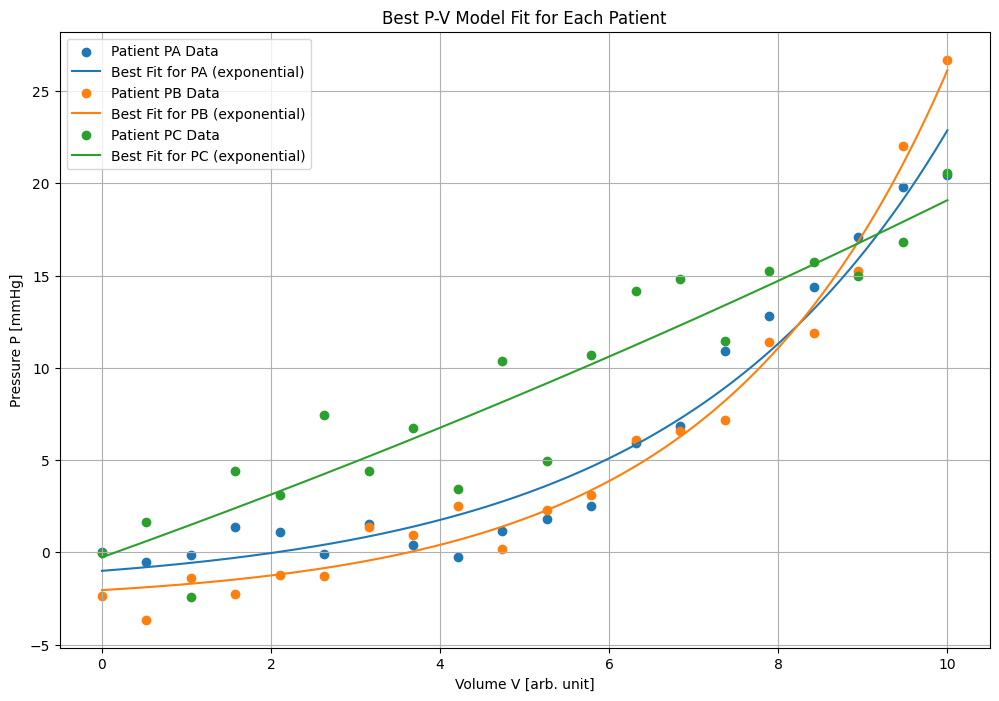

In [36]:
plt.figure(figsize=(12, 8))
for patient_id, data in df.iloc[:, 1:].items():
    plt.scatter(df['V'], data, label=f'Patient {patient_id} Data')
    best_model_info = best_models[patient_id]
    model_name = best_model_info['model_name']
    model_func = models[model_name]
    model_params = best_model_info['params']
    V_fit = np.linspace(min(df['V']), max(df['V']), 200)
    P_fit = model_func(V_fit, *model_params)
    plt.plot(V_fit, P_fit, label=f'Best Fit for {patient_id} ({model_name})')

plt.xlabel('Volume V [arb. unit]')
plt.ylabel('Pressure P [mmHg]')
plt.title('Best P-V Model Fit for Each Patient')
plt.legend()
plt.grid(True)
plt.show()


## Conclusions and Clinical Interpretation

The analysis showed that the exponential model best described the data for all patients. A comparison of vascular compliance (C) revealed significant clinical differences: Patient B is characterized by the highest compliance (most elastic vessels), while Patient C has the lowest compliance, which indicates significant arterial stiffness and increased cardiovascular risk.

## Answer to the Control Question

An increase in vascular resistance (R) in the Windkessel model leads to a lengthening of the pressure decay constant. This means that the pressure in the aorta falls more slowly, which is caused by the hindered outflow of blood from the arteries. This was confirmed on the generated plot, where the curve for the highest R value descends the most gently.
